# Preambolo
Ciò che cerco di fare con il seguente esperimento è di indurre 5 alberi di decisione, uno per ogni classe: ciascun albero sarà allenato sul training set così da classificare un punto come appartenente alla classe associata all'albero stesso o meno (classificazione one vs all). In particolare prevedo l'eventuale utilizzo della classe GridSearchCV così da indurre gli alberi caratterizzati da hyper-parametri ottimali rispetto ad una data score (come ad esempio l'accuratezza of f1_score balanced). Una volta che gli alberi one vs all con hyper-parametri ottimali sono stati indotti e le loro performance valutate  attraverso cross validation sul training set, procedo a ricavare per ciascun albero le probabilità che i punti del test set appartengano o meno alla classe associata all'albero. Per ciascun punto del test set determinerò qual è la classe a cui corrisponde la massima probabilità tra quelle appena ricavate, classificherò il punto come appartenente a quella classe e valuterò l'accuratezza di questo metodo di classificazione. Ricorda che qua hai eliminato sia 6 che 7 dal dataset

## Moduli importati

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC


## Importo il dataset

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)
df.head(10)

,Segni macro malignità,ADC,TIC type,T2,COD ISTO
0,0,1.60,A,1,3
1,0,1.00,B,0,4
2,0,1.20,C,0,3
3,0,0.77,B,1,4
4,0,0.80,C,1,1
5,1,0.70,C,1,1
6,0,0.90,B,1,4
7,0,0.70,B,1,4
8,0,0.80,B,1,4
9,0,1.40,A,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Segni macro malignità  103 non-null    int64  
 1   ADC                    103 non-null    float64
 2   TIC type               103 non-null    object 
 3   T2                     103 non-null    int64  
 4   COD ISTO               103 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 4.1+ KB


In [4]:
df['COD ISTO'].value_counts()

3    53
4    27
1    12
5     6
2     5
Name: COD ISTO, dtype: int64

## Samples e labels

In [5]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

## Esperimento

In [6]:
# X --> samples
# y --> labels

# tuned_parameters --> dizionario dove specificare gli hyper-paramethers da ottimizzare e il range di valori da 
# considerare per ciascuno di essi 

# test_size --> la frazione del dataset che costituisce il test set (stratificato). Di default è 0.2

# model_selection --> di default usa l'albero ottimo ottenuto da GridSearchCV. Se settato a qualsiasi altra cosa
#usa l'albero 
#di default costruito con DecisionTreeClassifier(),

# scorering_f --> la metrica rispetto alla quale voglio ottimizzare gli hyper-paramethers e valutare il classificaore
#finale. Di default utilizza l'accuratezza

# cv --> il numero di fold della cross validation utilizzata da gridSearchCv per valutare le performance degli alberi one vs all

# random_state_tree --> il seed dei DT, per riproducibilità. Di default è None

# n_it --> il numero di iterazioni

# verbose --> di default è False e determina un report relativamente compatto.

#Se posto True mostra un report contenente informazioni anche sulle performance di
# ciascun albero one vs all allenato nel corso delle iterazioni

def esperimento(X, y, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,9)),
                'min_samples_leaf': list(range(2,6)),'class_weight':['balanced']},
                test_size = 0.2, model_selection = 'gridsearch', scoring_f = accuracy_score,
                cv= 2, random_state_tree = None, n_it = 10, smotenc_aug = False, print_trees = False):
    
    proba_scores = []
    
    trees = []
    
    for n in range(n_it):
        print('### ITERATION %d ###\n\n' %(n+1))
        
        #metto shuffle a True senza specificare il random_state per ottenere split random ad ogni iterazione,
        #se facessi diversamente ad ogni iterazione avrei lo stesso test set e training set
        #pongo stratify = y per ottenere un test set e training set stratificato dove è presente almeno 
        #un sample delle
        #classi minoritarie
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                            shuffle = True, stratify = y)
        
        print('## Dataset split completed ##')
        
        if smotenc_aug == True:
            
            smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=[0,2,3,4,5],
                          sampling_strategy = 'minority')
            
            for i in range(4):
                
                X_train, y_train = smt.fit_resample(X_train, y_train)
                
            print('## SMOTENC augmentation completed ##')
     
        #dizionari che contengono le labels binarie da utilizzare per allenare i DT one vs all
        bin_y_train = dict()
        bin_y_test = dict()
        
        for i in range(1,6):
            bin_y_train[i] = [1 if x == i else 0 for x in y_train ]
            bin_y_test[i] = [1 if x == i else 0 for x in y_test ]
        
        print('## Binary labels prepared ##')
        
        #dizionario per contenere le probabilità ottenute da ciascun DT one vs all nell'iterazione corrente
        predict_proba = dict()
        
        #induzione dei 5 DT one vs all
        current_trees = []
        for n_tree in range(1,6):
            
            print('# Tuning hyper-parameters DT one vs all n.%d #\n' %(n_tree))
            
            clf = tree.DecisionTreeClassifier(random_state = random_state_tree)
            
            #preparo lo scorer
            scorer = None
            
            if scoring_f is f1_score:
                
                scorer = make_scorer(f1_score, average = 'weighted')
            else:
                scorer = make_scorer(scoring_f)
                
            
            if model_selection == 'gridsearch':
                
                clf = GridSearchCV(clf, tuned_parameters, scoring = scorer, cv = cv, refit = True)
                clf.fit(X_train, bin_y_train[n_tree])
                params = clf.best_params_
                score_ = clf.best_score_
                current_trees.append(clf.best_estimator_)
                
            else:
                
                scores = cross_val_score(clf, X_train, bin_y_train[n_tree], scoring = scorer, cv = cv )
                clf = clf.fit(X_train, bin_y_train[n_tree])
                params = clf.get_params()
                score_ = scores.mean()
                current_trees.append(clf)
                
            
            print("Parameters set found:\n")
            print(params)
            print()
            print('Scoring function used: ')
            print(scorer)
            print("Cross-validated score of the estimator: %0.3f\n" %( score_))
           
                
            predict_proba[n_tree] = clf.predict_proba(X_test)[:,1]
            print('-'*100)
        
        trees.append(current_trees)

        print('# Probabilities aggregation #\n')
        
        array = np.array( [predict_proba[1],  predict_proba[2],  predict_proba[3],  
                           predict_proba[4], predict_proba[5]])
        array = np.transpose(array)
        y_pred_proba = np.argmax(array, axis = 1)+1
        
        print('Final classifier performance:')
        print(classification_report( y_test, y_pred_proba, zero_division = 0))
        if scoring_f is f1_score:
            proba_score = f1_score(y_test, y_pred_proba, average = 'weighted')
        else:
            proba_score = scoring_f(y_test, y_pred_proba)
        proba_scores.append(proba_score)
        
    print('\n\n### Mean final score: %0.3f , Std dev: %0.3f ###' %( np.mean(proba_scores), np.std(proba_scores)))
    
    if print_trees :
        print('\n\n### Best trees based on selected scoring function: ###')
        best_iteration = np.argmax(proba_scores)
        print('Referred iteration: {}'.format(best_iteration+1))
        best_trees = trees[best_iteration]
        
        fig, ax = plt.subplots(5,1)
        fig.set_size_inches(25, 15)
        
        for n,t in enumerate(best_trees):
            print('Tree {} vs all'.format(n+1))
            print(t.get_params())
            tree.plot_tree(t,
               feature_names = X.columns,
               class_names = ['0','1'], filled = True, rounded = True, ax = ax[n])
            

In [7]:
#Utilizzo gridsearch, balanced, accuracy come scoring function, no augmentation

seed = 42

esperimento(X, y, random_state_tree = seed)

### ITERATION 1 ###


## Dataset split completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.951

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_s

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.976

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.927

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         1
           3       0.89      0.73      0.80        11
           4       1.00      1.00      1.00

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.890

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.890

-----------------------------------------------------------

In [8]:
#Utilizzo gridsearch, balanced, accuracy come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.967

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.890

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.852

-----------------------------------------------------------

## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.971

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_

In [9]:
#Utilizzo gridsearch, balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.981

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_dept

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.936

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.991

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.959

-----------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.803

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.88      0.64      0.74        11
           4       1.00      1.00      1.00         6
           5       0.20      1.00      0.33         1

    accuracy                           0.76        21
   macro avg       0.82      0.83      0.75        21
weighted avg       0.90      0.76      0.80        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tu

In [10]:
#Utilizzo gridsearch, not balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score,
           tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,9)),
                'min_samples_leaf': list(range(2,6)),'class_weight':[None]})

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.982

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_sample

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.938

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.817

-----------------------------------------

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.950

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       0.90      0.82      0.86        11
           4       1.00      1.00      1.00         6
           5       0.00      0.00      0.00         1

    accuracy                           0.86        21
   macro avg       0.78      0.76      0.77        21
weighted avg       0.90      0.86      0.88        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning h

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.949

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_dept

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.901

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.973

-----------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.818

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         1
           3       0.82      0.82      0.82        11
           4       1.00      1.00      1.00         6
           5       0.00      0.00      0.00         1

    accuracy                           0.81        21
   macro avg       0.66      0.66      0.66        21
weighted avg       0.81      0.81      0.81        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tu

Tree 1 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 2 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 3 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 4 vs all
{'ccp_alpha

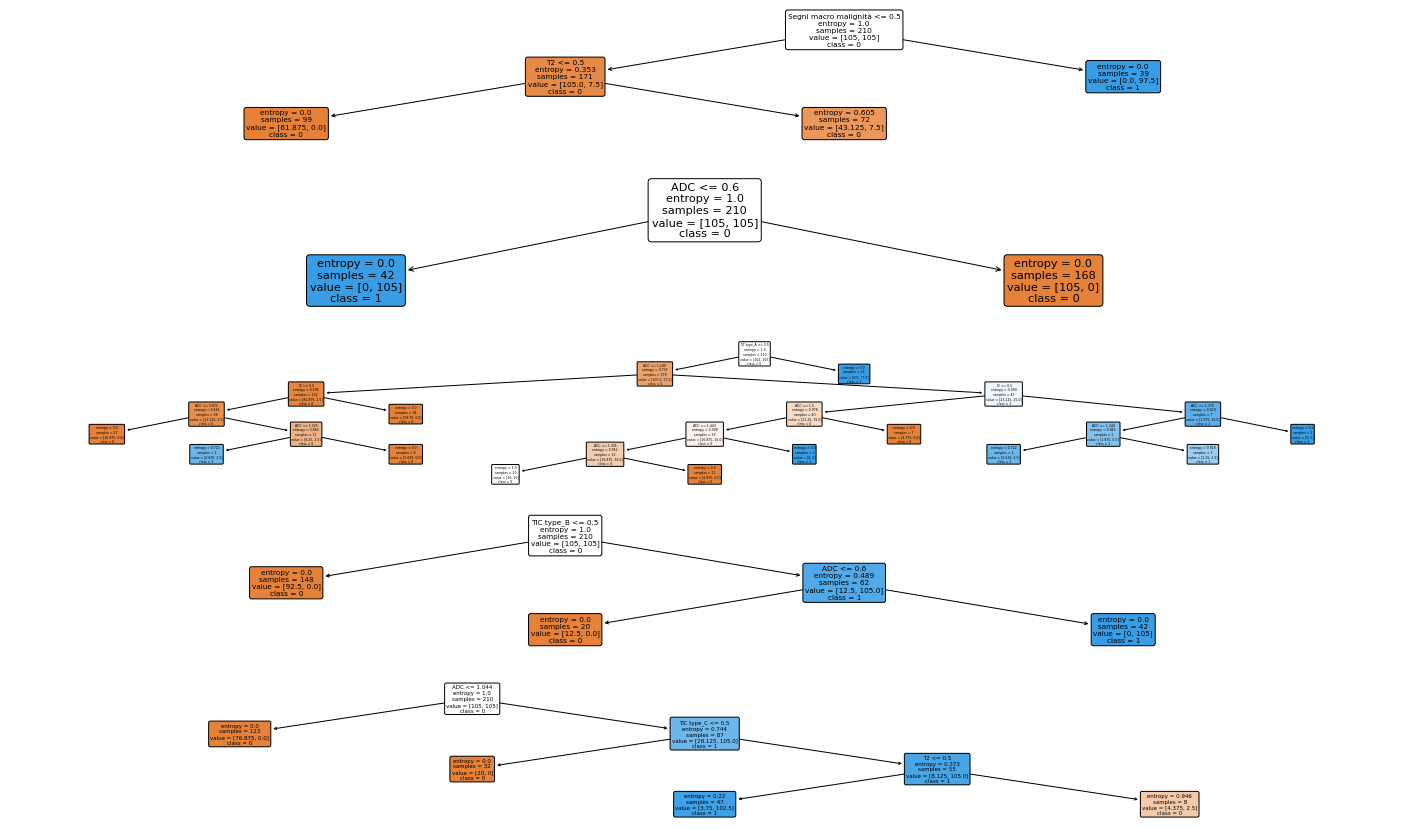

In [11]:
#ora estraggo i la quintupla di alberi one vs all migliori
#Utilizzo gridsearch, balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, print_trees = True)


### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.977

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_dept

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.966

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.977

-----------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.964

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         1
           3       1.00      0.64      0.78        11
           4       1.00      1.00      1.00         6
           5       0.25      1.00      0.40         1

    accuracy                           0.81        21
   macro avg       0.78      0.93      0.80        21
weighted avg       0.93      0.81      0.84        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tu

Tree 1 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 2 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 3 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 4 vs all
{'ccp_alpha

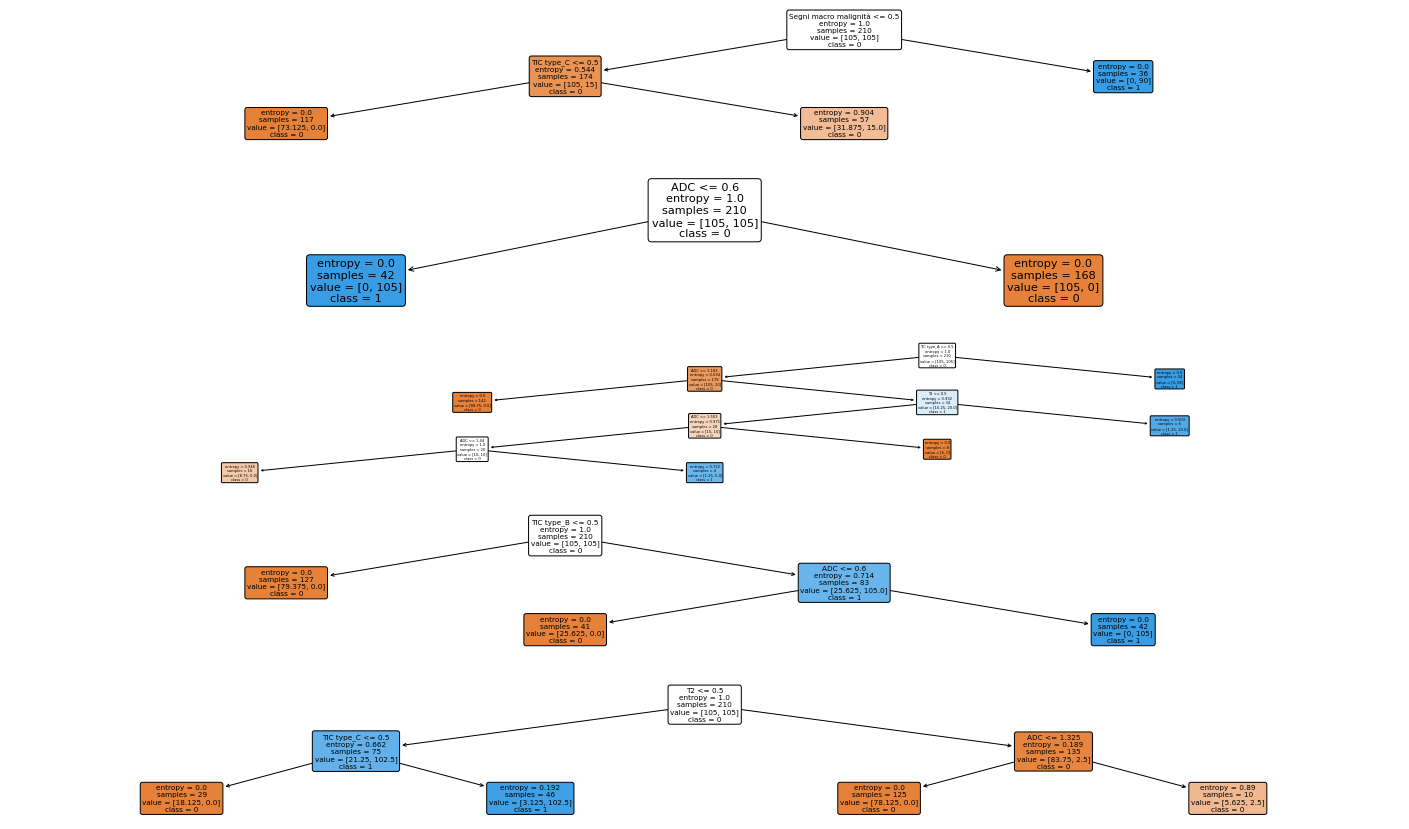

In [12]:
#ora estraggo i la quintupla di alberi one vs all migliori
#Utilizzo gridsearch, balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, print_trees = True)


### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.986

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_dept

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.970

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.841

-----------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.808

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         1
           3       0.90      0.82      0.86        11
           4       1.00      1.00      1.00         6
           5       0.00      0.00      0.00         1

    accuracy                           0.86        21
   macro avg       0.71      0.76      0.73        21
weighted avg       0.87      0.86      0.86        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tu

Tree 1 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 2 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 3 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 4 vs all
{'ccp_alpha

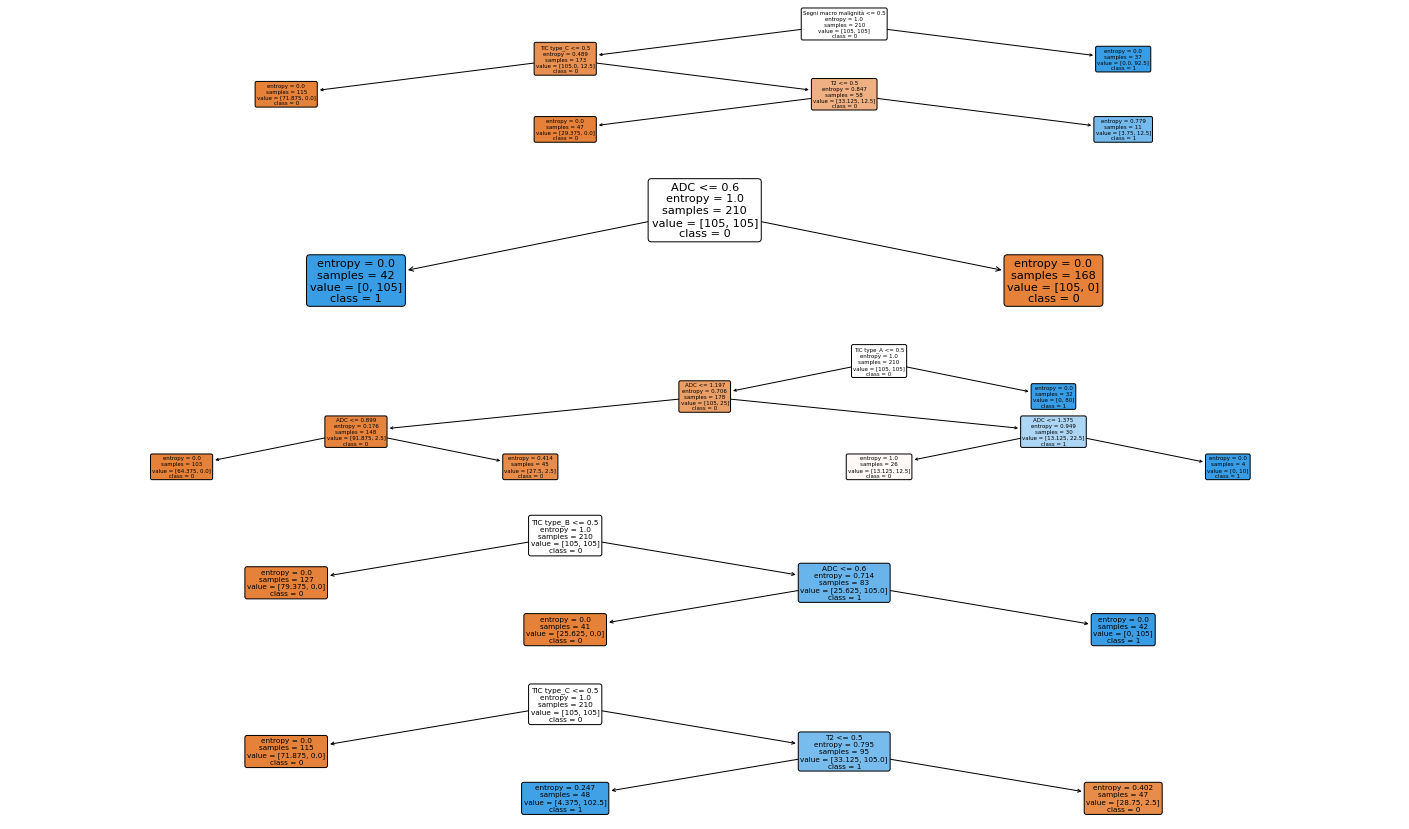

In [13]:
#ora estraggo i la quintupla di alberi one vs all migliori
#Utilizzo gridsearch, balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, print_trees = True)


### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.973

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_dept

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.814

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.5 #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.827

-----------------------

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.810

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      0.64      0.78        11
           4       1.00      1.00      1.00         6
           5       0.20      1.00      0.33         1

    accuracy                           0.81        21
   macro avg       0.84      0.93      0.82        21
weighted avg       0.96      0.81      0.85        21

### ITERATION 8 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tu

Tree 1 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 2 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 3 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 4 vs all
{'ccp_alpha

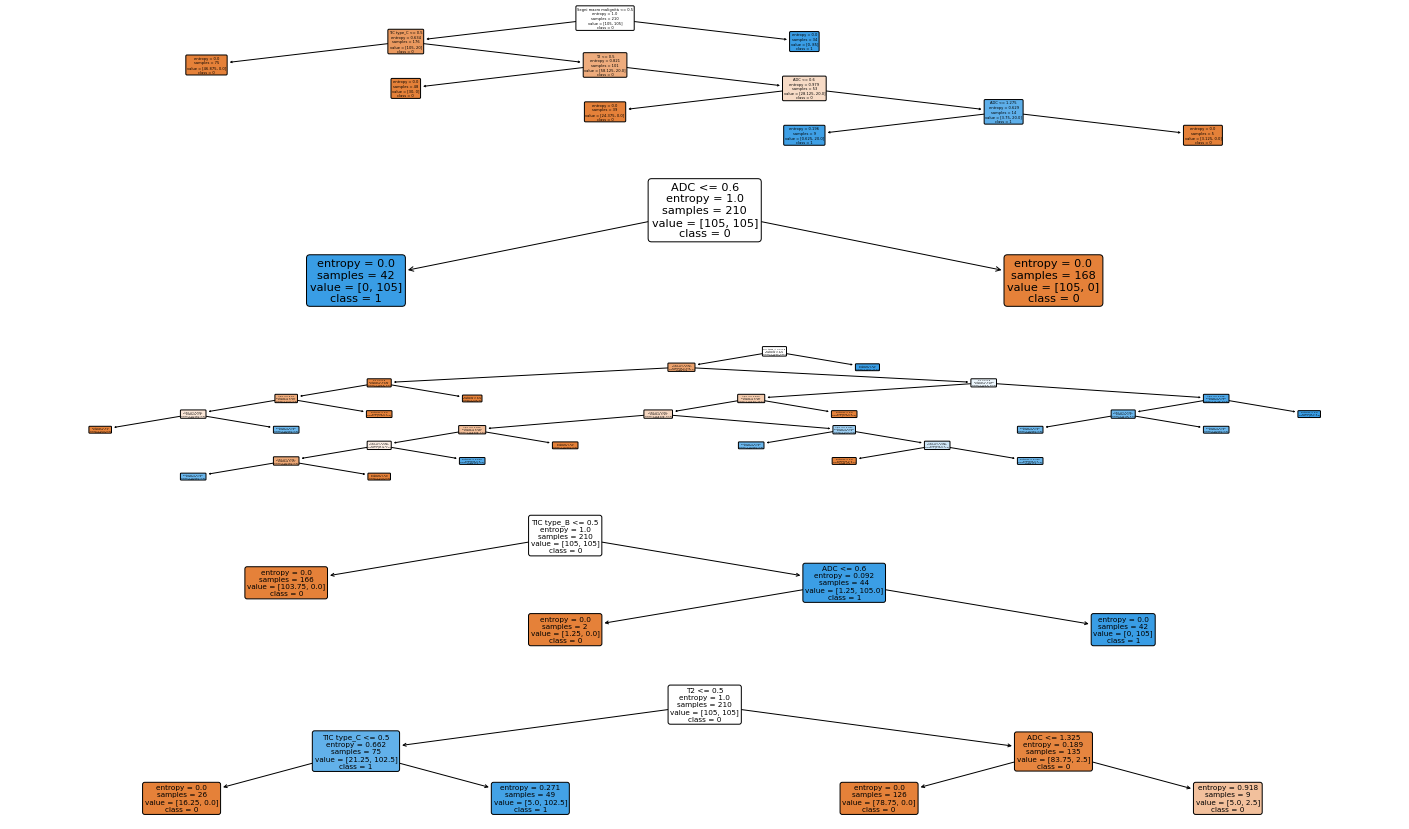

In [14]:
#ora estraggo i la quintupla di alberi one vs all migliori
#Utilizzo gridsearch, balanced, f1 come scoring function, con augmentation

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, print_trees = True)
